# Interpatient tumor heterogeneity via somatic mutations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from CodebookStats import zeta, eta

In [3]:
from tqdm import tqdm
from joblib import Parallel, delayed

In [4]:
from adjustText import adjust_text

In [5]:
%%time
cosmic_df = pd.read_csv('../COSMIC_data/Cosmic_CompleteTargetedScreensMutant_v99_GRCh38.tsv.gz', sep='\t', usecols=['COSMIC_SAMPLE_ID', 'COSMIC_PHENOTYPE_ID', 'COSMIC_GENE_ID'], compression='gzip')
cosmic_df.dropna(inplace=True)
cosmic_df.drop_duplicates(inplace=True)

CPU times: user 1min 29s, sys: 5.21 s, total: 1min 34s
Wall time: 1min 35s


In [6]:
sample_classif = pd.read_csv('../COSMIC_data/Cosmic_Classification_v99_GRCh38.tsv.gz', sep='\t', na_values='NS', compression='gzip')

In [7]:
sample_classif['PRIMARY_SITE_HISTOLOGY'] = sample_classif['PRIMARY_SITE'] + '_' + sample_classif['PRIMARY_HISTOLOGY']

In [8]:
gene_census = pd.read_csv('../COSMIC_data/Cosmic_CancerGeneCensus_v99_GRCh38.tsv.gz', sep='\t', usecols=['COSMIC_GENE_ID', 'CHROMOSOME'], index_col=0, compression='gzip')

In [9]:
# Select only known cancer genes from census
cosmic_df = cosmic_df[cosmic_df['COSMIC_GENE_ID'].isin(gene_census.index)]

In [10]:
cosmic_df = cosmic_df.merge(sample_classif, how='left', on='COSMIC_PHENOTYPE_ID')

In [11]:
mut_tables = dict()
for cancer_type in tqdm(set(cosmic_df['PRIMARY_SITE_HISTOLOGY'])):
    cosmic_subset = cosmic_df[cosmic_df['PRIMARY_SITE_HISTOLOGY'] == cancer_type]
    mut_tables[cancer_type] = pd.crosstab(cosmic_subset['COSMIC_SAMPLE_ID'], cosmic_subset['COSMIC_GENE_ID']) 
    mut_tables[cancer_type] = mut_tables[cancer_type] > 0

100%|██████████| 352/352 [05:06<00:00,  1.15it/s]


In [12]:
melanomas = cosmic_df[cosmic_df['PRIMARY_HISTOLOGY'] == 'malignant_melanoma']
melanoma_mut_table = pd.crosstab(melanomas['COSMIC_SAMPLE_ID'], melanomas['COSMIC_GENE_ID'])
melanoma_mut_table = melanoma_mut_table.loc[melanoma_mut_table.sum(axis=1) >= 10, :]
melanoma_mut_table = melanoma_mut_table.loc[:, melanoma_mut_table.sum() >= 5]

In [13]:
gliomas = cosmic_df[cosmic_df['PRIMARY_HISTOLOGY'] == 'glioma']
glioma_mut_table = pd.crosstab(gliomas['COSMIC_SAMPLE_ID'], gliomas['COSMIC_GENE_ID'])
glioma_mut_table = glioma_mut_table.loc[glioma_mut_table.sum(axis=1) >= 10, :]
glioma_mut_table = glioma_mut_table.loc[:, glioma_mut_table.sum() >= 5]

## Pan-cancer tumor heterogeneity

In [14]:
mut_tables_p = {k : sum(v.mean() >= 0.001) for k, v in mut_tables.items()}

In [15]:
mut_tables_filt = {k : v.loc[:, v.mean() >= 0.001] for k, v in mut_tables.items()}

In [16]:
cancer_types = [k for k, v in mut_tables_filt.items() if ('other' not in str(k)) & (v.shape[0] >= 1000) & (v.shape[1] >= 100)]

In [17]:
k = 20
rng = np.random.default_rng(seed=42)

results = dict()
for c in tqdm(cancer_types):
    # print(c)
    v = mut_tables_filt[c]
    def f(s):
        e = v.sample(n=1000, random_state=s)
        z = np.mean(zeta(e, k=k))
        h = np.mean(eta(e, k=k))
        return {'zeta' : z, 'eta' : h}

    results[c] = Parallel(n_jobs=-2)(delayed(f)(s) for s in rng.integers(2 ** 32, size=100))

results = pd.DataFrame(results).unstack().apply(pd.Series).reset_index(level=0).rename(columns={'level_0' : 'cancer_type'})

100%|██████████| 53/53 [58:10<00:00, 65.87s/it]   


In [18]:
cancer_nomenclature = {
    # 'breast_fibroepithelial_neoplasm' : 'breast fibroepithelial neoplasm',
    # 'ovary_low_malignant_potential_(borderline)_tumour'
    'adrenal_gland_pheochromocytoma' : 'pheochromocytoma',
    'meninges_meningioma' : 'meningioma',
    'testis_germ_cell_tumour' : 'testicular germ cell tumor',
    'autonomic_ganglia_paraganglioma' : 'paraganglioma',
    'small_intestine_carcinoma' : 'small intestine carcinoma',
    'thyroid_adenoma-nodule-goitre' : 'thyroid adenoma',
    'soft_tissue_synovial_sarcoma' : 'synovial sarcoma',
    'stomach_carcinoma' : 'gastric carcinoma',
    'central_nervous_system_primitive_neuroectodermal_tumour-medulloblastoma' : 'medulloblastoma',
    'soft_tissue_leiomyosarcoma' : 'leiomyosarcoma',
    'bone_Ewing_sarcoma-peripheral_primitive_neuroectodermal_tumour' : 'Ewing sarcoma',
    'upper_aerodigestive_tract_carcinoma' : 'upper aerodigestive tract carcinoma',
    'soft_tissue_liposarcoma' : 'liposarcoma',
    'soft_tissue_schwannoma' : 'schwannoma',
    'kidney_carcinoma' : 'renal carcinoma',
    'autonomic_ganglia_neuroblastoma' : 'neuroblastoma',
    'lung_carcinoma' : 'lung carcinoma',
    # 'soft_tissue_undifferentiated_sarcoma'
    'liver_carcinoma' : 'hepatic carcinoma',
    'salivary_gland_carcinoma' : 'salivary gland carcinoma',
    'pleura_mesothelioma' : 'pleural mesothelioma',
    'thyroid_carcinoma' : 'thyroid carcinoma',
    # 'pancreas_carcinoid-endocrine_tumour' : 'pancreatic carcinoid-endocrine tumor',
    'haematopoietic_and_lymphoid_tissue_haematopoietic_neoplasm' : 'hematopoietic neoplasm',
    # 'ovary_sex_cord-stromal_tumour' 
    'urinary_tract_carcinoma' : 'urinary tract carcinoma',
    # skin_benign_melanocytic_nevus' : 'benign melanocytic nevus',
    'bone_osteosarcoma' : 'osteosarcoma',
    # 'skin_adnexal_tumour' : 'adnexal tumor',
    'biliary_tract_carcinoma' : 'cholangiocarcinoma',
    'skin_malignant_melanoma' : 'malignant melanoma',
    'soft_tissue_gastrointestinal_stromal_tumour' : 'gastrointestinal stromal tumor',
    'oesophagus_carcinoma' : 'esophageal carcinoma',
    'pancreas_carcinoma' : 'pancreatic carcinoma',
    'cervix_carcinoma' : 'cervical carcinoma',
    # 'small_intestine_carcinoid-endrocrine_tumour' : 'small intestine carcinoid-endocrine tumor',
    'adrenal_gland_adrenal_cortical_carcinoma' : 'adrenocortical carcinoma',
    'breast_carcinoma' : 'breast carcinoma',
    'skin_carcinoma' : 'skin carcinoma',
    # 'soft_tissue_malignant_peripheral_nerve_sheath_tumour'
    'bone_chondrosarcoma' : 'chondrosarcoma',
    # 'gastrointestinal_tract_(site_indeterminate)_carcinoma'
    'endometrium_carcinoma' : 'endometrial carcinoma',
    'large_intestine_carcinoma' : 'colorectal carcinoma',
    'haematopoietic_and_lymphoid_tissue_lymphoid_neoplasm' : 'lymphoid neoplasm',
    'central_nervous_system_glioma' : 'glioma',
    'prostate_carcinoma' : 'prostate carcinoma',
    'ovary_carcinoma' : 'ovarian carcinoma',
    # 'soft_tissue_sarcoma' : 'sarcoma',
    'soft_tissue_rhabdomyosarcoma' : 'rhabdomyosarcoma',
    'eye_malignant_melanoma' : 'ocular melanoma',
}

In [19]:
res = results[results['cancer_type'].isin(cancer_nomenclature.keys())]

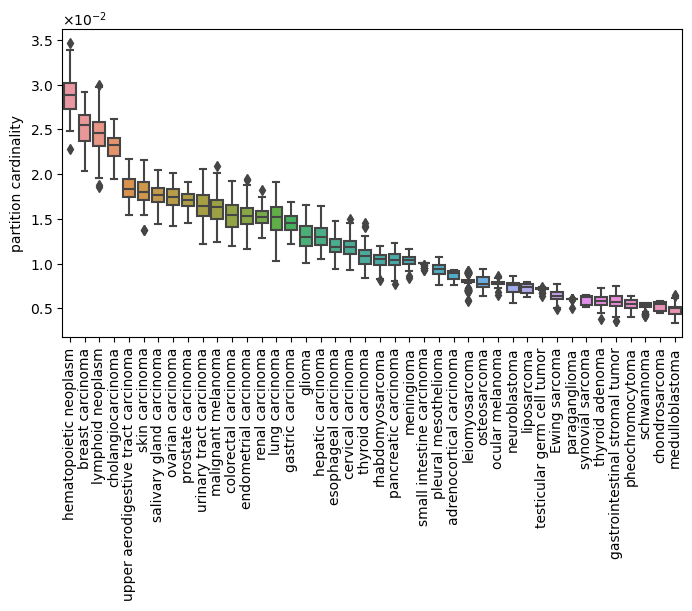

In [20]:
plt.figure(figsize=(8,4))
g = sns.boxplot(
    data=res,
    x='cancer_type',
    order=res.groupby('cancer_type')['zeta'].mean().sort_values(ascending=False).index,
    y='zeta'
)
g.tick_params('x', rotation=90)
ticks = g.get_xticklabels()
g.set_xticklabels([cancer_nomenclature.get(t.get_text()) for t in ticks])

g.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

g.set_xlabel('')
g.set_ylabel('partition cardinality')
plt.show()

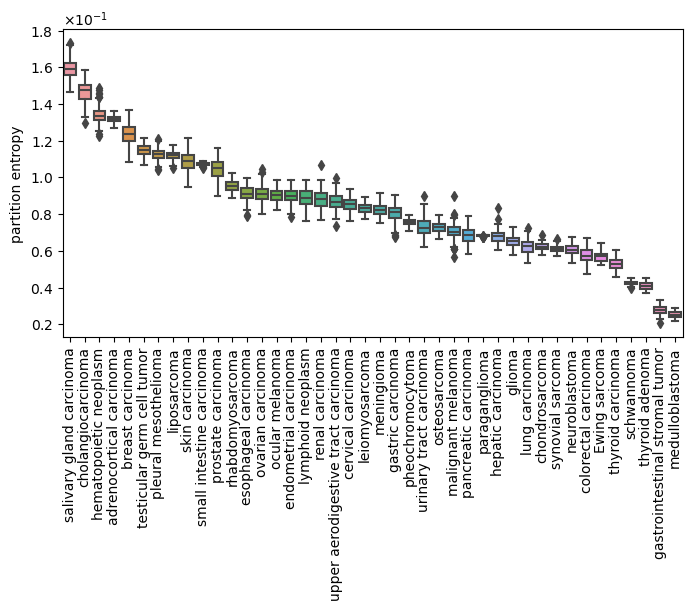

In [21]:
plt.figure(figsize=(8,4))
g = sns.boxplot(
    data=res,
    x='cancer_type',
    order=res.groupby('cancer_type')['eta'].mean().sort_values(ascending=False).index,
    y='eta'
)
g.tick_params('x', rotation=90)
ticks = g.get_xticklabels()
g.set_xticklabels([cancer_nomenclature.get(t.get_text()) for t in ticks])

g.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

g.set_xlabel('')
g.set_ylabel('partition entropy')
plt.show()

## Melanomas and gliomas, stratified by chromosomes

In [22]:
chrs = [str(x) for x in np.arange(1, 23)]+ ['X']

In [23]:
k = 20
num_trials = 100
sample_size = 20
rng = np.random.default_rng(seed=42)

melanoma_chr_controls = []
for _ in tqdm(range(num_trials)):
    e = melanoma_mut_table.sample(n=sample_size, axis=1, random_state=rng)
    p = np.mean(np.ravel(e))
    p = np.maximum(p, 1-p)

    z = np.mean(zeta(e, k=k))
    h = np.mean(eta(e, k=k))

    melanoma_chr_controls.append({'sparsity' : p, 'zeta': z, 'eta' : h})

melanoma_chr_controls = pd.DataFrame(melanoma_chr_controls)

100%|██████████| 100/100 [13:35<00:00,  8.15s/it]


In [24]:
k = 20
num_trials = 100
sample_size = 20
rng = np.random.default_rng(seed=42)

glioma_chr_controls = []
for _ in tqdm(range(num_trials)):
    e = glioma_mut_table.sample(n=sample_size, axis=1, random_state=rng)
    p = np.mean(np.ravel(e))
    p = np.maximum(p, 1-p)

    z = np.mean(zeta(e, k=k))
    h = np.mean(eta(e, k=k))

    glioma_chr_controls.append({'sparsity' : p, 'zeta': z, 'eta' : h})

glioma_chr_controls = pd.DataFrame(glioma_chr_controls)

100%|██████████| 100/100 [06:16<00:00,  3.77s/it]


In [25]:
k = 20
melanoma_chr_results = dict()
for c in tqdm(chrs):
    genes = melanoma_mut_table.columns.intersection(gene_census[gene_census['CHROMOSOME'] == c].index)
    e = melanoma_mut_table[genes]
    
    p = np.mean(np.ravel(e))
    p = np.maximum(p, 1-p)
    z = np.mean(zeta(e, k=k))
    h = np.mean(eta(e, k=k))

    melanoma_chr_results[c] = {'sparsity' : p, 'zeta': z, 'eta' : h}

melanoma_chr_results = pd.DataFrame(melanoma_chr_results).T

100%|██████████| 23/23 [02:55<00:00,  7.64s/it]


In [26]:
k = 20
glioma_chr_results = dict()
for c in tqdm(chrs):
    genes = glioma_mut_table.columns.intersection(gene_census[gene_census['CHROMOSOME'] == c].index)
    e = glioma_mut_table[genes]
    
    p = np.mean(np.ravel(e))
    p = np.maximum(p, 1-p)
    z = np.mean(zeta(e, k=k))
    h = np.mean(eta(e, k=k))

    glioma_chr_results[c] = {'sparsity' : p, 'zeta': z, 'eta' : h}

glioma_chr_results = pd.DataFrame(glioma_chr_results).T

100%|██████████| 23/23 [01:26<00:00,  3.75s/it]


/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


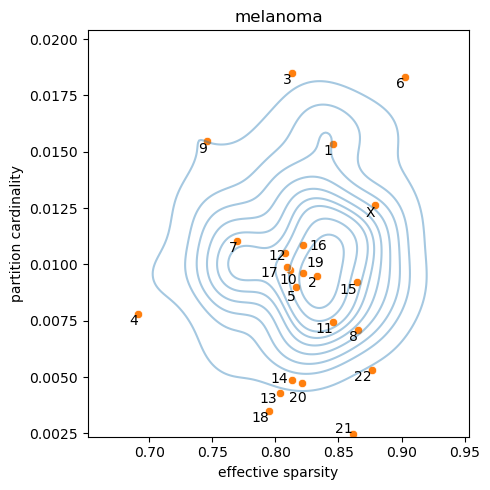

In [27]:
plt.figure(figsize=(5,5))
ax = plt.gca()

sns.kdeplot(data=melanoma_chr_controls, x='sparsity', y='zeta', alpha=0.4, ax=ax)
sns.scatterplot(data=melanoma_chr_results, x='sparsity', y='zeta', c='tab:orange', ax=ax)
texts = [ax.text(r[1]['sparsity'], r[1]['zeta'], r[0]) for r in melanoma_chr_results.iterrows()]
adjust_text(texts, ax=ax)
ax.set_title('melanoma')
ax.set_xlabel('effective sparsity')
ax.set_ylabel('partition cardinality')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


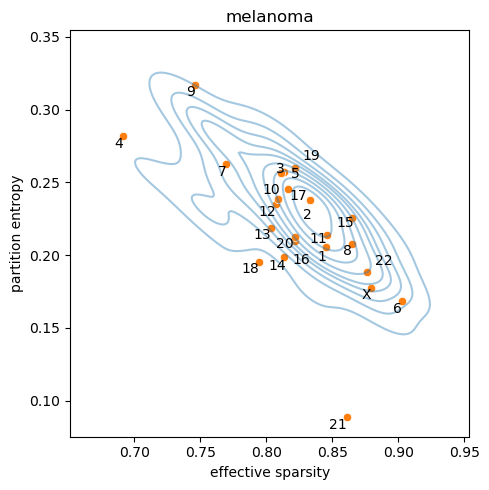

In [28]:
plt.figure(figsize=(5,5))
ax = plt.gca()

sns.kdeplot(data=melanoma_chr_controls, x='sparsity', y='eta', alpha=0.4, ax=ax)
sns.scatterplot(data=melanoma_chr_results, x='sparsity', y='eta', c='tab:orange', ax=ax)
texts = [ax.text(r[1]['sparsity'], r[1]['eta'], r[0]) for r in melanoma_chr_results.iterrows()]
adjust_text(texts, ax=ax)
ax.set_title('melanoma')
ax.set_xlabel('effective sparsity')
ax.set_ylabel('partition entropy')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


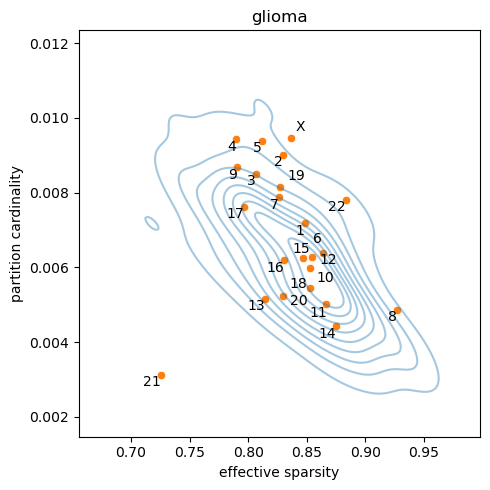

In [29]:
plt.figure(figsize=(5,5))
ax = plt.gca()

sns.kdeplot(data=glioma_chr_controls, x='sparsity', y='zeta', alpha=0.4, ax=ax)
sns.scatterplot(data=glioma_chr_results, x='sparsity', y='zeta', c='tab:orange', ax=ax)
texts = [ax.text(r[1]['sparsity'], r[1]['zeta'], r[0]) for r in glioma_chr_results.iterrows()]
adjust_text(texts, ax=ax)
ax.set_title('glioma')
ax.set_xlabel('effective sparsity')
ax.set_ylabel('partition cardinality')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/working/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


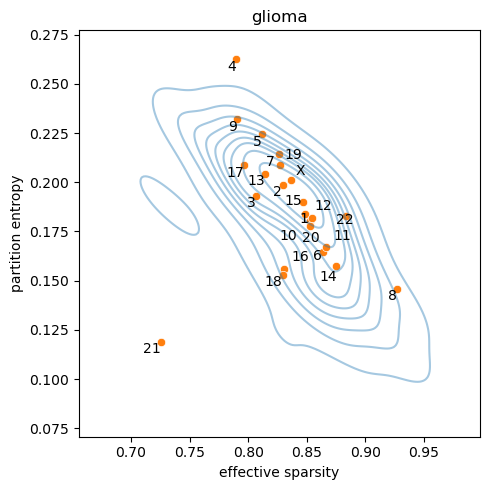

In [30]:
plt.figure(figsize=(5,5))
ax = plt.gca()

sns.kdeplot(data=glioma_chr_controls, x='sparsity', y='eta', alpha=0.4, ax=ax)
sns.scatterplot(data=glioma_chr_results, x='sparsity', y='eta', c='tab:orange', ax=ax)
texts = [ax.text(r[1]['sparsity'], r[1]['eta'], r[0]) for r in glioma_chr_results.iterrows()]
adjust_text(texts, ax=ax)
ax.set_title('glioma')
ax.set_xlabel('effective sparsity')
ax.set_ylabel('partition entropy')

plt.tight_layout()
plt.show()